Exploratory Data Analysis

In [199]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

cashrequest_df = pd.read_csv("project_dataset/cashreq-clean.csv")
fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")
print("✅ done!")

# Fórmula de LTV por usuario = Suma de todas las fees que ha pagado ese usuario
# sum of all fee_amount from fees-with-cohort-and-user-id-clean.csv where user_id matches

# Fórmula de LTV por cohort:  Promedio de LTV de todos los usuarios en ese cohort
# LTV_cohort = average of all LTV_user values within the same cohort

✅ done!


/var/folders/bx/bzgj6qhd5_l2_b7d0v7r7r7r0000gn/T/ipykernel_5666/3950483872.py:7: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")


In [200]:
# cashrequest_df.head()

In [201]:
# fees_and_cohorts_df.head()

## LTV per user / cohort

In [202]:
# Ingreso total generado por los usuarios de cada cohorte / Número de usuarios en la cohorte
# Los gráficos representarán el LTV promedio por usuario de cada cohorte.

In [203]:
# Q1: Sumar ingresos per user / cohort
user_total_per_cohort = fees_and_cohorts_df.groupby(["cohort", "user_id"])["total_amount"].sum().reset_index()
user_total_per_cohort.head()

,cohort,user_id,total_amount
0,2019-11,47.0,50.0
1,2019-12,52.0,10.0
2,2019-12,53.0,5.0
3,2019-12,77.0,5.0
4,2019-12,92.0,15.0


In [204]:
# Q2: Revenue promedio per user / cohort
avg_revenue_per_user_by_cohort = user_total_per_cohort.groupby("cohort")["total_amount"].mean().reset_index()
avg_revenue_per_user_by_cohort.columns = ["cohort", "avg_revenue_per_user"]
avg_revenue_per_user_by_cohort.head()

,cohort,avg_revenue_per_user
0,2019-11,50.000000
1,2019-12,18.081395
2,2020-01,18.714286
3,2020-02,21.444444
4,2020-03,18.510638


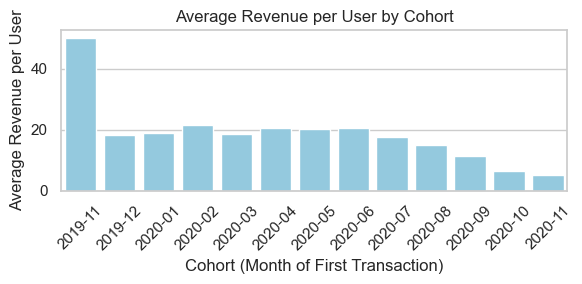

'🧠 Interpretation of Results:\n✅ 2019-11 cohort has the highest average revenue per user, by far — almost $50 per user, which may indicate:\n+ Very engaged early adopters\n+ A small but high-value user base\n+ Or longer time to accumulate revenue\n\n📉 From 2019-12 to mid-2020, average revenue per user remains fairly stable (~$18–$21) — these cohorts might have more consistent behavior.\n\n⬇️ Starting around 2020-08, there’s a clear downward trend:\nCohorts like 2020-09, 2020-10, and 2020-11 show much lower user value, around $5–$10 per user, this could indicate:\n+ Decreased user engagement\n+ Shorter lifetime (users haven\'t been active long enough)\n+ Lower conversion or retention quality\n+ Or you’re acquiring lower-value users as you scale"\n'

In [205]:
# Q2 Plotting
plt.figure(figsize=(6, 3))
sns.barplot(
    data=avg_revenue_per_user_by_cohort,
    x="cohort",
    y="avg_revenue_per_user",
    color="skyblue"
)

# Titles and labels
plt.title("Average Revenue per User by Cohort")
plt.xlabel("Cohort (Month of First Transaction)")
plt.ylabel("Average Revenue per User")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

"""🧠 Interpretation of Results:
✅ 2019-11 cohort has the highest average revenue per user, by far — almost $50 per user, which may indicate:
+ Very engaged early adopters
+ A small but high-value user base
+ Or longer time to accumulate revenue

📉 From 2019-12 to mid-2020, average revenue per user remains fairly stable (~$18–$21) — these cohorts might have more consistent behavior.

⬇️ Starting around 2020-08, there’s a clear downward trend:
Cohorts like 2020-09, 2020-10, and 2020-11 show much lower user value, around $5–$10 per user, this could indicate:
+ Decreased user engagement
+ Shorter lifetime (users haven't been active long enough)
+ Lower conversion or retention quality
+ Or you’re acquiring lower-value users as you scale"
"""


In [206]:
# Q3: Ver en cuántas cohorts ha estado cada usuario
cohorts_per_user = fees_and_cohorts_df.groupby("user_id")["cohort"].nunique().reset_index()
cohorts_per_user.columns = ["user_id", "num_cohorts_active"]
cohorts_per_user.head()

,user_id,num_cohorts_active
0,47.0,1
1,52.0,1
2,53.0,1
3,72.0,1
4,73.0,1


In [207]:
# Q4: Asociar a cada user con su cohort de entrada (primer préstamo):
user_first_cohort = fees_and_cohorts_df.groupby("user_id")["cohort"].min().reset_index()
user_first_cohort.columns = ["user_id", "cohort_start"]
# Unir con el número de cohorts activos
user_lifetime_df = pd.merge(user_first_cohort, cohorts_per_user, on="user_id")

# Calcular duración promedio por cohorte
# Ahora, para cada cohort de entrada (cohort_start), sacamos el promedio de cohorts activos por usuario:
avg_duration_per_cohort = user_lifetime_df.groupby("cohort_start")["num_cohorts_active"].mean().reset_index()
avg_duration_per_cohort.columns = ["cohort", "avg_num_cohorts_active"]

# Ya tenemos el ingreso promedio por usuario (paso anterior), ahora, unirlo y multiplicar:
ltv_by_cohort = pd.merge(avg_revenue_per_user_by_cohort, avg_duration_per_cohort, on="cohort")

# Calculamos LTV por user
ltv_by_cohort["LTV"] = ltv_by_cohort["avg_revenue_per_user"] * ltv_by_cohort["avg_num_cohorts_active"]
ltv_by_cohort

,cohort,avg_revenue_per_user,avg_num_cohorts_active,LTV
0,2019-11,50.000000,1.0,50.000000
1,2019-12,18.081395,1.0,18.081395
2,2020-01,18.714286,1.0,18.714286
3,2020-02,21.444444,1.0,21.444444
4,2020-03,18.510638,1.0,18.510638
5,2020-04,20.357143,1.0,20.357143
6,2020-05,20.308219,1.0,20.308219
7,2020-06,20.599817,1.0,20.599817
8,2020-07,17.561350,1.0,17.561350
9,2020-08,15.000000,1.0,15.000000


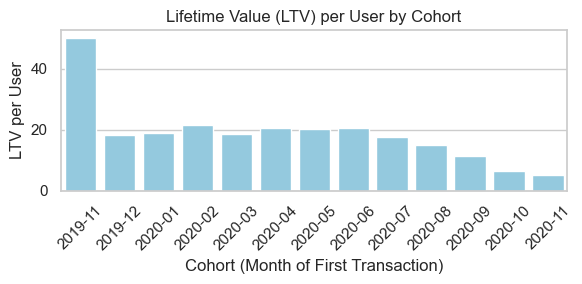

In [208]:
# Q4: Plotting

plt.figure(figsize=(6, 3))
sns.barplot(
    data=ltv_by_cohort,
    x="cohort",
    y="LTV",
    color="skyblue"
)

plt.title("Lifetime Value (LTV) per User by Cohort")
plt.xlabel("Cohort (Month of First Transaction)")
plt.ylabel("LTV per User")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [209]:
# Q5: Separar el fee por el tipo de fee
# Sumar ingresos por user + fee type + cohort
revenue_by_user_type = fees_with_cohort.groupby(["cohort_start", "user_id", "type"])["total_amount"].sum().reset_index()

# Paso 2: Promedio por fee type + cohort
avg_revenue_by_type = revenue_by_user_type.groupby(["cohort_start", "type"])["total_amount"].mean().reset_index()
avg_revenue_by_type.columns = ["cohort", "fee_type", "avg_revenue_per_user"]
avg_revenue_by_type

,cohort,fee_type,avg_revenue_per_user
0,2019-11,instant_payment,20.000000
1,2019-11,postpone,30.000000
2,2019-12,incident,9.137931
3,2019-12,instant_payment,9.014085
4,2019-12,postpone,13.541667
5,2020-01,incident,9.375000
6,2020-01,instant_payment,8.548387
7,2020-01,postpone,14.318182
8,2020-02,incident,9.230769
9,2020-02,instant_payment,10.000000


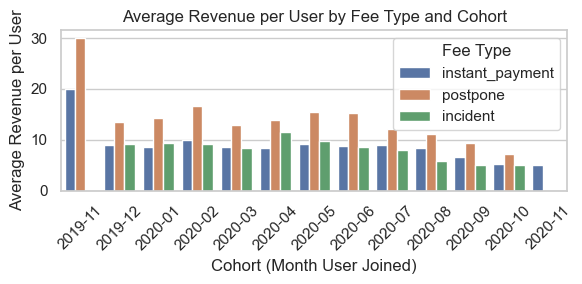

In [210]:
#Q5: Plotting

plt.figure(figsize=(6, 3))
sns.barplot(
    data=avg_revenue_by_type,
    x="cohort",
    y="avg_revenue_per_user",
    hue="fee_type"
)

plt.title("Average Revenue per User by Fee Type and Cohort")
plt.xlabel("Cohort (Month User Joined)")
plt.ylabel("Average Revenue per User")
plt.xticks(rotation=45)
plt.legend(title="Fee Type")
plt.tight_layout()
plt.show()

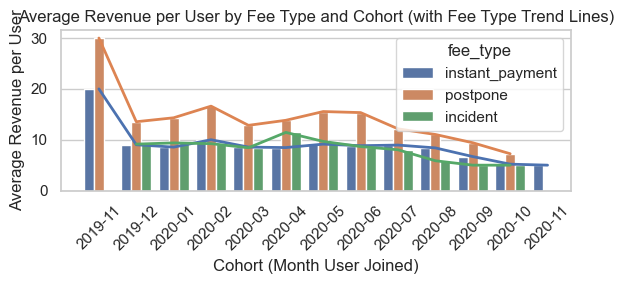

In [211]:
plt.figure(figsize=(6, 3))

# Barras por tipo de fee
sns.barplot(
    data=avg_revenue_by_type,
    x="cohort",
    y="avg_revenue_per_user",
    hue="fee_type"
)

# Línea por tipo de fee (superpuesta)
sns.lineplot(
    data=avg_revenue_by_type,
    x="cohort",
    y="avg_revenue_per_user",
    hue="fee_type",
    markers=True,
    linewidth=2,
    legend=False  # opcional si ya está la leyenda arriba
)

plt.title("Average Revenue per User by Fee Type and Cohort (with Fee Type Trend Lines)")
plt.xlabel("Cohort (Month User Joined)")
plt.ylabel("Average Revenue per User")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Interpretation of Results:

✅ 2019-11 cohort has the highest average revenue per user, by far — almost $50 per user.
+ Users generated almost $30 in postpone fees alone, more than any other cohort or fee type.

which may indicate:
+ Very engaged early adopters
+ A small but high-value user base
+ Or longer time to accumulate revenue

📉 From 2019-12 to mid-2020, average revenue per user remains fairly stable (~$18–$21) — these cohorts might have more consistent behavior.
+ postpone remains dominant, but not as extreme as in 2019-11.

⬇️ Starting around 2020-08, there’s a clear downward trend (all fee types):
Cohorts like 2020-09, 2020-10, and 2020-11 show much lower user value, around $5–$10 per user, this could indicate:
+ Decreased user engagement
+ Shorter lifetime (users haven't been active long enough)
+ Lower conversion or retention quality
+ Or you’re acquiring lower-value users as you scale"

🧩 The incident fee type:
+ Has a relatively consistent presence since 2020-01.